Import all the libraries which are used for importing the dataset and creating the network.

In [ ]:
import numpy as np
import torch
import torchvision
from time import time
from torch import nn, optim

Create static variables that will be used later. These variables consists of values such as the rate at which the network learns from the data.

In [8]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [9]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST\raw\train-images-idx3-ubyte.gz to /files/MNIST\raw


Extracting /files/MNIST\raw\train-labels-idx1-ubyte.gz to /files/MNIST\raw


Extracting /files/MNIST\raw\t10k-images-idx3-ubyte.gz to /files/MNIST\raw


Extracting /files/MNIST\raw\t10k-labels-idx1-ubyte.gz to /files/MNIST\raw
Processing...
Done!


In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [13]:
example_data.shape

torch.Size([1000, 1, 28, 28])

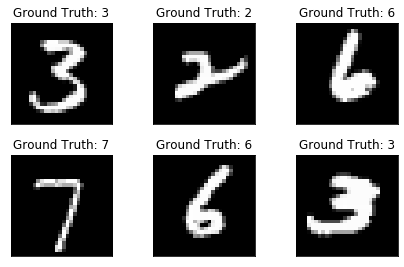

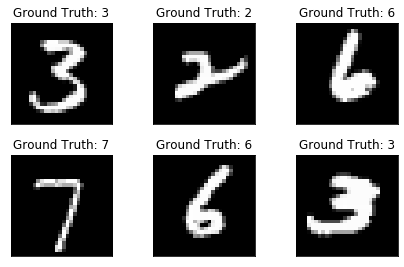

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [17]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [21]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [22]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0021, -0.0021, -0.0021,  ..., -0.0021, -0.0021, -0.0021],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        ...,
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012]])


In [33]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.15307656925386076
Epoch 1 - Training loss: 0.11777385837956468
Epoch 2 - Training loss: 0.09510059139705193
Epoch 3 - Training loss: 0.07875976421590299
Epoch 4 - Training loss: 0.06626592060255168
Epoch 5 - Training loss: 0.0564698965779182
Epoch 6 - Training loss: 0.04897260083394971
Epoch 7 - Training loss: 0.042273039836486156
Epoch 8 - Training loss: 0.03601180850059044
Epoch 9 - Training loss: 0.031213504227890033
Epoch 10 - Training loss: 0.027365261643155933
Epoch 11 - Training loss: 0.023861696627159822
Epoch 12 - Training loss: 0.020445688905915232
Epoch 13 - Training loss: 0.01771633128666861
Epoch 14 - Training loss: 0.01558591919383461

Training Time (in minutes) = 4.102704767386118


In [38]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 6


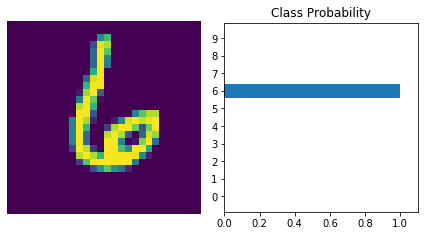

In [63]:
images, labels = next(iter(test_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)